In [ ]:
# In a tree model, some features whose importances are larger than 0 are used to split the data,
# while other features are not. But this does not mean those features not in use are bad absolutly,
# we can only say they are less useful and contain less information compared with those factors in use.
# Many reasons account for this, including limited tree depth which not allows us to use all features.

# So how to exploit all the features' information? Here is an UNPROVEN idea:
# A boosting model based on building a tree model to split features according to their importance

# In a tree model, we usually split data according to the features, but here we split features according to theri importance, for example:
# In the beginning, we have 10 features and we bulid a tree model(maybe a basic tree model or a lightgbm model or others), assuming in this tree model, 
# The using time for 10 features is w0 = [9,8,7,4,2,1,0,0,0,0], which can used to measure their importance.
# Then we split 10 features into 2 groups according whether their using time is larger than 0. 
# So in this case, we get [f1,f2,f3,f4,f5,f6] in group 1 and [f7,f8,f9,f10] in group 2.
# We build a tree model for each feature group and repeat above operations.
# This process will stop in limited steps for we will stop split this node if the nums of features in it is 1 or all features are used in a tree model built by them.
# Suppose finally we split 10 features into 6 groups, for example: [f1,f2,f3],[f4,f5],[f6,f7],[f8],[f9],[f10], and we get a tree model for each group.
# Our final model is a weighted mean of those 6 models. The weight for ith feature is defined as:
#                       (w0i+1) / \Sum(w0k+1) for k from 1 to 10
# and the weight for the model built by group i is equal to the sum of weight of the features in this group.
# So far we have finished all steps and this ipynb is to test whether this method is useful to improve the model performance.

In [ ]:
# A boosting model for regression is most likely to get a prediction varying in a narrow interval, for example: the prediction for y is almost near 0.
# for the essence of boosting is to average a basket of models and when using average, the variation will be smaller.
# So useing MSE to measure whether the model is imporved when boosting them is not reasonable.
# Maybe comparing IC is a better way.

In [1]:
import pandas as pd
import numpy as np
import lightgbm
from mypython import PurgedGroupTimeSeriesSplit as tss
from sklearn import metrics

import time
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)[:,1]

# 继承kfold类之后n_splits不能设置为1了 那也太不好用了
cv = tss.PurgedGroupTimeSeriesSplit(n_splits=2)
(train_index1, test_index1), (train_index2, test_index2) = cv.split_2(x,y,groups)

/home/qianshuofu/anaconda3/envs/rapids-22.12/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n_groups:964,n_splits:2
group_test_starts:range(642, 964, 161)
group_train_starts:range(0, 322, 161)


<Axes: title={'center': 'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

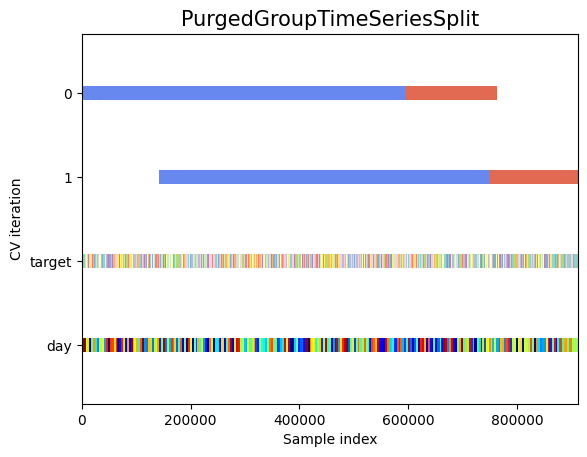

In [60]:
fig, ax = plt.subplots()
tss.plot_cv_indices(cv,x,y,groups,ax,split_method=False)

In [3]:
train_dataset = lightgbm.Dataset(x[train_index1],y[train_index1])
model = lightgbm.train(params={},train_set=train_dataset)

feature_importance = model.feature_importance()

feature_useful_index = [i for i in range(len(feature_importance)) if feature_importance[i] > 0]
feature_useless_index = [i for i in range(len(feature_importance)) if feature_importance[i] == 0]

train_dataset_le = lightgbm.Dataset(x[train_index1][:,feature_useful_index],y[train_index1])
train_dataset_ri = lightgbm.Dataset(x[train_index1][:,feature_useless_index],y[train_index1])

model_le = lightgbm.train(params={},train_set=train_dataset_le)
model_ri = lightgbm.train(params={},train_set=train_dataset_ri)

feature_importance_le = model_le.feature_importance()
feature_importance_ri = model_ri.feature_importance()


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.689220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256275
[LightGBM] [Info] Number of data points in the train set: 602539, number of used features: 1005
[LightGBM] [Info] Start training from score -0.002323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.221225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193545
[LightGBM] [Info] Number of data points in the train set: 602539, number of used features: 759
[LightGBM] [Info] Start training from score -0.002323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62730
[LightGBM] [Info] Number of data points in the train set: 602539, number of used features: 246
[Lig

In [4]:
y_pred = model.predict(x[test_index1])

y_pred_le = model_le.predict(x[test_index1][:,feature_useful_index])
y_pred_ri = model_ri.predict(x[test_index1][:,feature_useless_index])
group_importance_le = feature_importance[feature_useful_index]
group_importance_ri = feature_importance[feature_useless_index]
weight_le = (sum(group_importance_le) + len(group_importance_le)) / (sum(feature_importance) + len(feature_importance))
weight_ri = (sum(group_importance_ri) + len(group_importance_ri)) / (sum(feature_importance) + len(feature_importance))
y_pred_mean = weight_le*y_pred_le + weight_ri*y_pred_ri

y_true = y[test_index1]
metrics.mean_squared_error(y_true,y_pred),metrics.mean_squared_error(y_true,y_pred_mean)

(1.000571904073437, 1.0006243661755627)

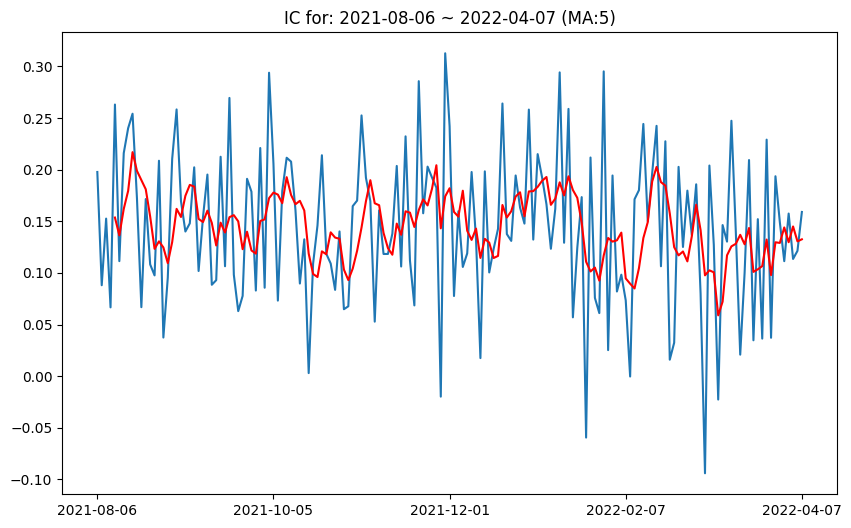

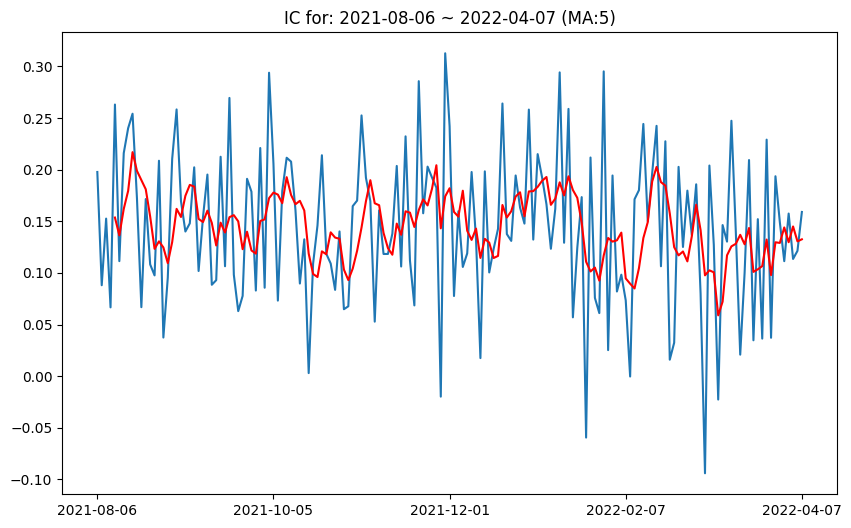

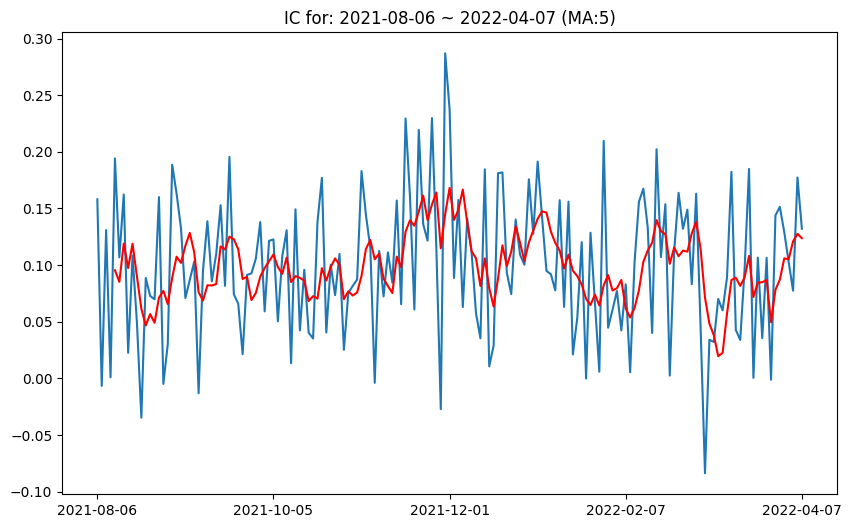

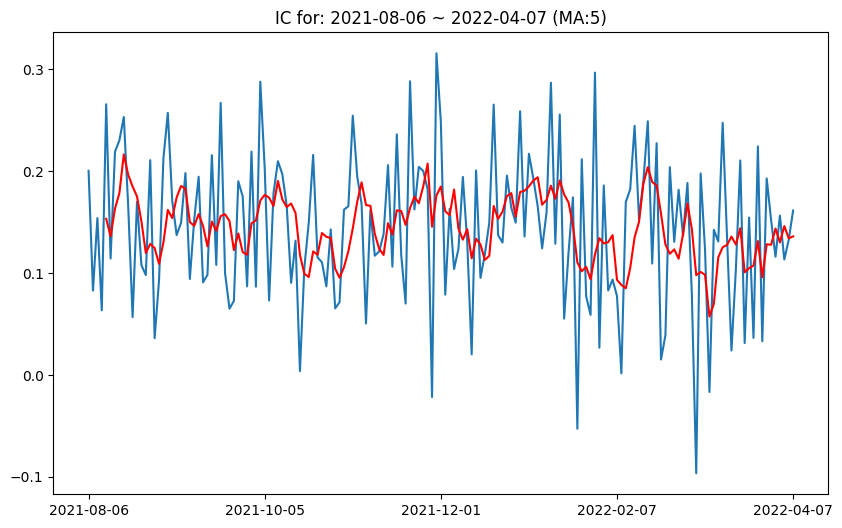

In [7]:
tss.plot_ic(y,[test_index1],[y_pred],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_le],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_ri],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_mean],groups,ma=5,continuous=True)

-0.00023550167294304246


Text(0.5, 1.0, 'The diff of IC between initial model and le_ri model')

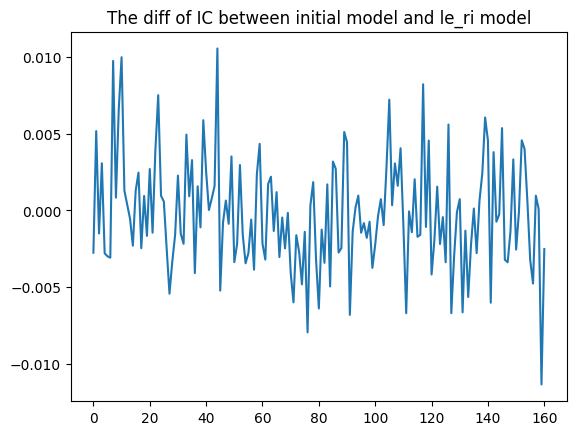

In [66]:
u,ic = tss.calculate_ic(y_true,y_pred,groups[test_index1])
u_mean,ic_mean = tss.calculate_ic(y_true,y_pred_mean,groups[test_index1])
ic_diff = np.array(ic) - np.array(ic_mean)
print(ic_diff.mean())
plt.plot(ic_diff)
plt.title('The diff of IC between initial model and le_ri model')

|         IC_mean|      le_IC_mean|      ri_IC_mean|  weight_IC_mean|
|:--------------:|:--------------:|:--------------:|:--------------:|
|        0.144468|        0.144468|       0.099055 |        0.144704|

In [ ]:
# After one split in features, the mean of ic in test_index1 data improve by a little.
# And from the figure, there is no apparent improve

# The possible reason: the group2 features can not contribute too much to the result
# Try: split the features into two groups randomly

In [45]:
import random
random.seed(42)

random_index = list(range(x.shape[1]))
random.shuffle(random_index)
feature_le_index,feature_ri_index = random_index[:x.shape[1]//2],random_index[x.shape[1]//2:]

train_le_random = lightgbm.Dataset(x[train_index1][:,feature_le_index],y[train_index1])
model_le_random = lightgbm.train(params={},train_set=train_le_random)
train_ri_random = lightgbm.Dataset(x[train_index1][:,feature_ri_index],y[train_index1])
model_ri_random = lightgbm.train(params={},train_set=train_ri_random)

y_pred_le_random = model_le_random.predict(x[test_index1][:,feature_le_index])
y_pred_ri_random = model_ri_random.predict(x[test_index1][:,feature_ri_index])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.775932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126480
[LightGBM] [Info] Number of data points in the train set: 602539, number of used features: 496
[LightGBM] [Info] Start training from score -0.002323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.761018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129795
[LightGBM] [Info] Number of data points in the train set: 602539, number of used features: 509
[LightGBM] [Info] Start training from score -0.002323


In [46]:
y_pred_random = (y_pred_le_random + y_pred_ri_random)/2
metrics.mean_squared_error(y_true,y_pred),metrics.mean_squared_error(y_true,y_pred_random)

(1.000571904073437, 1.0003598403886287)

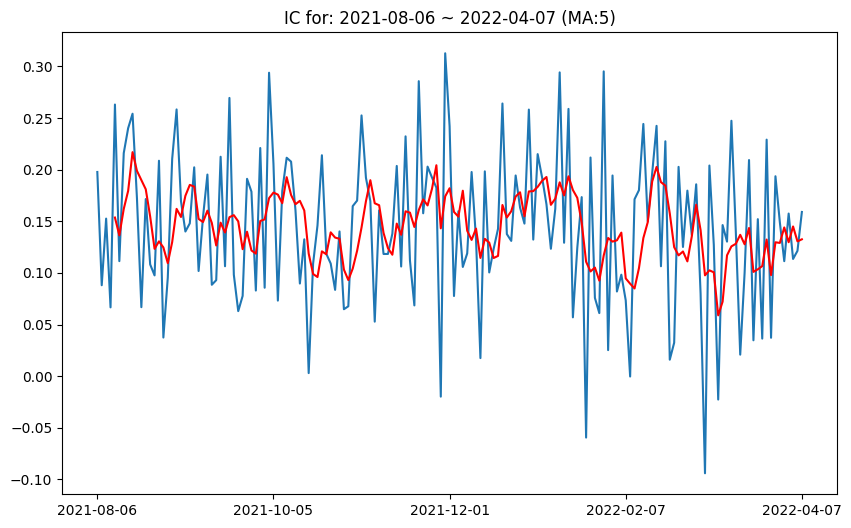

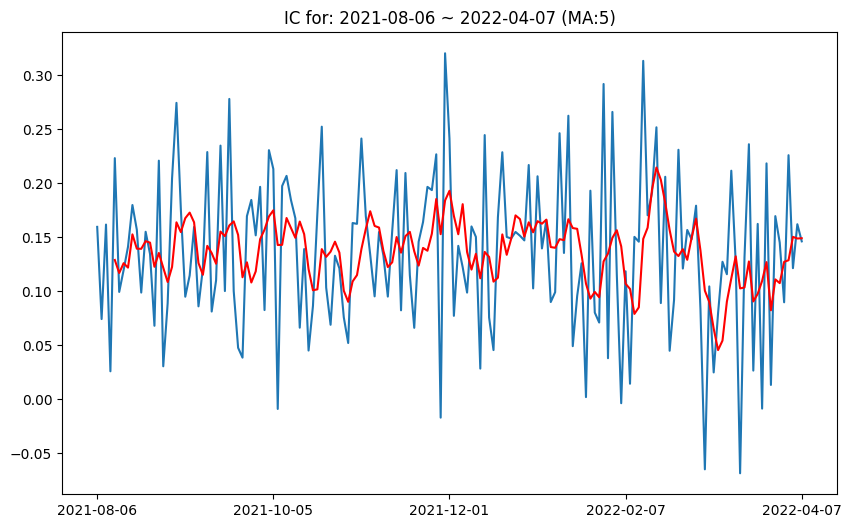

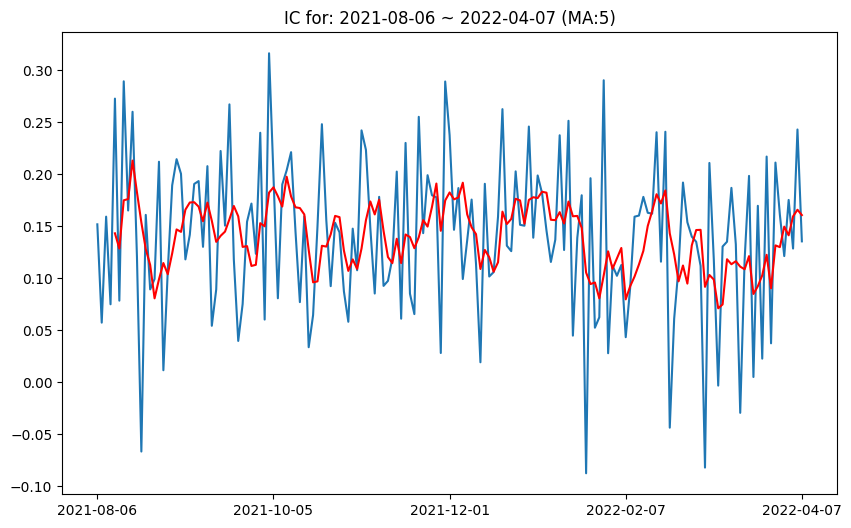

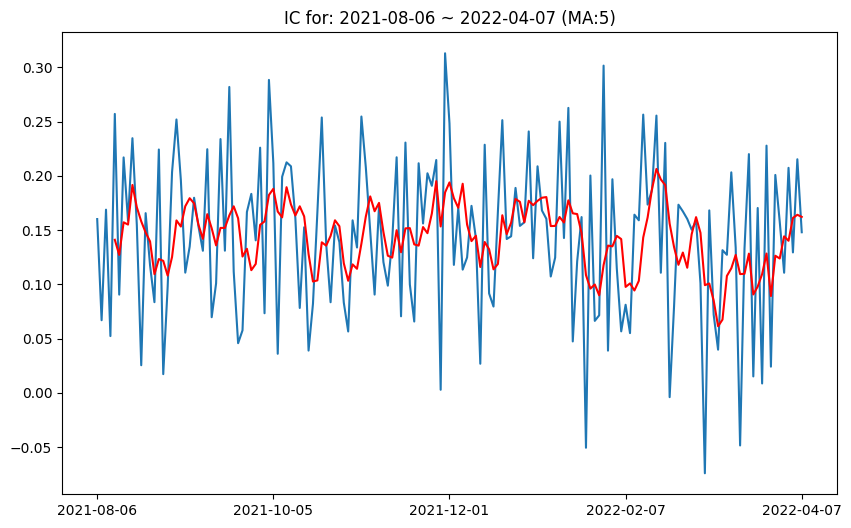

In [47]:
tss.plot_ic(y,[test_index1],[y_pred],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_le_random],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_ri_random],groups,ma=5,continuous=True)
tss.plot_ic(y,[test_index1],[y_pred_random],groups,ma=5,continuous=True)

0.0005615448049725716


Text(0.5, 1.0, 'The diff of IC between initial model and random model')

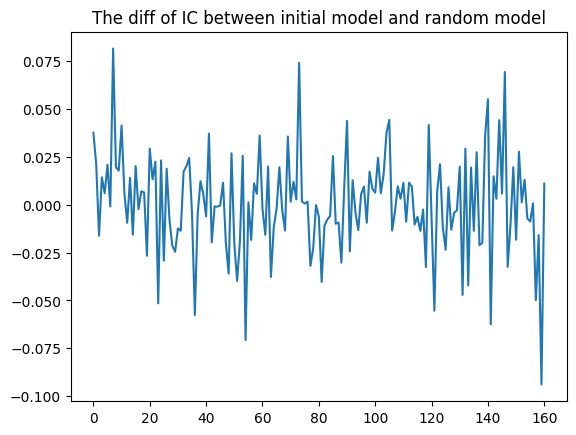

In [72]:
u,ic = tss.calculate_ic(y_true,y_pred,groups[test_index1])
u_random,ic_random = tss.calculate_ic(y_true,y_pred_random,groups[test_index1])
ic_diff_random = np.array(ic) - np.array(ic_random)
print(ic_diff_random.mean())
plt.plot(ic_diff_random)
plt.title('The diff of IC between initial model and random model')

|         IC_mean|le_IC_mean_random|ri_IC_mean_random|  random_IC_mean|
|:--------------:|:---------------:|:---------------:|:--------------:|
|        0.144468|         0.136836|         0.140206|        0.143907|

In [ ]:
# If we split features into two groups with the same lens randomly, the ic for each model bulit by them is worse than the initial one.
# And the ic of the combined model is also worse than the initial one.

# So if want to improve the model by spliting features, the first method is better.
# Next: test what if we repeat the operation in the first method.
# But my guess is: there will be a little imporve but only a little.

# If my guess is right, how about limiting the max_depth in the model to promote the model for more branches and leaves

In [ ]:
# Another UNPROVEN thought:
# Suppose we have y_true and y_pred_1, y_pred_2, the ic between y_true and y_pred_1 is a (a > 0), and ic between y_true and y_pred_2 is b (b > 0).
# Can we prove that: The ic between y_true and the linear combination of y_pred_1 and y_pred_2 is larger than both a and b ?

# My guess: The idea is most likely wrong, but is there some special cases?

In [ ]:
# Next: 
# - Split features into two groups: first 90 percent and last 10 percent according to their importance, use the second model to predict the residual of the first model
# - Try to change the y, use open-to-close returns and 2d,3d,etc returns, observe the decline trend when d increase.
# - Build a sample strategy: such as long the fist 10 percent and short the last 10 percent every day.